In [2]:
from binascii import a2b_qp
import json
from nis import match
from MemoryEntry import MemoryEntry
from MemoryBank import MemoryBank
from typing import List
import argparse
from MemoryBank import MemoryBank
from tqdm import tqdm
from consistency import check_consistency, Implication, check_accuracy
import utils
import json
import torch
import sklearn
import matplotlib.pyplot as plt
from models import *
import tensorflow as tf
import numpy as np
from tqdm import tqdm

import torch



In [3]:
def find(data, constraint):
    for d in data:
        if d.relation == constraint.source and d.answer == constraint.ans[0]:
            return d.entity
    return 'It'

def test_constraint_knowledge(config=baseline_config, contra_test=False):
    constraints = json.load(open("data/constraints_v2.json"))
    constraints = [Implication(c) for c in constraints["links"]]
    data_filename = f"data/silver_facts.json"
    data = utils.json_to_tuples(json.load(open(data_filename)))

    yess = []
    nos = []
    for d in data:
        m = MemoryEntry(d[0], d[1], answer=d[2])
        if m.answer == 'yes':
            yess += [m]
        else:
            nos += [m]

    bank = MemoryBank(config)
    entity_results_entailment = []
    entity_results_neutral = []
    entity_results_contradiction = []
    for constraint in tqdm(constraints):
        # find an entity for which this is true
        entity = find(yess, constraint)
        a = MemoryEntry(entity=entity, relation=constraint.source, answer=constraint.ans[0])
        b = MemoryEntry(entity=entity, relation=constraint.target, answer=constraint.ans[1])
        if contra_test:
            if b.answer == 'yes':
                b.answer = 'no'
            elif b.answer == 'no':
                b.answer = 'yes'
        e_result =bank.get_relation(a.get_declarative_statement(), b.get_declarative_statement())
        entity_results_entailment += [e_result[0]]
        entity_results_neutral += [e_result[1]]
        entity_results_contradiction += [e_result[2]]
    
    all_results = np.vstack((entity_results_entailment, entity_results_neutral, entity_results_contradiction))
    decision = np.argmax(all_results, axis=0)
    print(f"Entailment: {np.sum(decision == 0)}, Neutral: {np.sum(decision == 1)}, Contradiction: {np.sum(decision == 2)}")
    return entity_results_entailment, entity_results_neutral, entity_results_contradiction

In [4]:
orig = test_constraint_knowledge(baseline_config)

100%|██████████| 4060/4060 [01:26<00:00, 47.08it/s]

Entailment: 1750, Neutral: 2115, Contradiction: 195


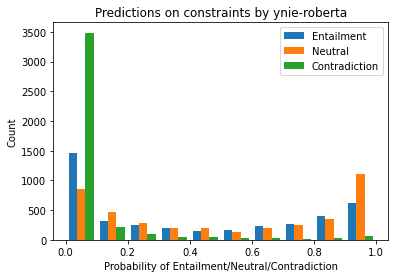

In [9]:
def plot(title, entity_results_entailment, entity_results_neutral, entity_results_contradiction):
    plt.hist([entity_results_entailment, entity_results_neutral, entity_results_contradiction], range=(0, 1), label=["Entailment", "Neutral", "Contradiction"])
    plt.legend()
    plt.xlabel("Probability of Entailment/Neutral/Contradiction")
    plt.ylabel("Count")
    plt.title(title)
    plt.savefig(f"final_figures/{title.replace('/', '_')}.png", dpi=1200)
    plt.show()
    plt.close()
plot("Predictions on constraints by ynie-roberta", *orig)

What if we flip the hypothesis and look for contradictions?
For example the constraint "IsA,cat" -> "HasA,hair" directly doesn't yield entailment:
It is a cat. </s></s> It has hair
CONTRADICTION 0.006
NEUTRAL 0.731
ENTAILMENT 0.262
But the contradiction: "It is a cat. </s></s> It does not have hair" yield contradiction:
CONTRADICTION 0.952
NEUTRAL 0.045
ENTAILMENT 0.004

But what about statements that are truly neutral? 
A dog has a nose. </s></s> A dog is not a table
CONTRADICTION 0.180
NEUTRAL 0.398
ENTAILMENT 0.422

100%|██████████| 4060/4060 [01:25<00:00, 47.69it/s]


Entailment: 445, Neutral: 1472, Contradiction: 2143


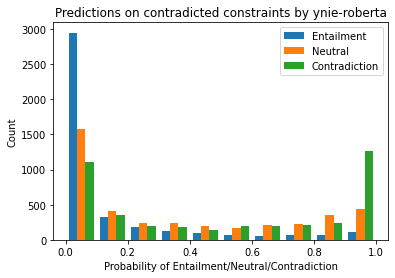

In [12]:
orig_contra = test_constraint_knowledge(baseline_config, contra_test=True)
plot("Predictions on contradicted constraints by ynie-roberta", *orig_contra)

In [13]:
roberta = test_constraint_knowledge(roberta_flip_config)

Downloading:   0%|          | 0.00/688 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

100%|██████████| 4060/4060 [01:24<00:00, 48.08it/s]

Entailment: 1597, Neutral: 2075, Contradiction: 388


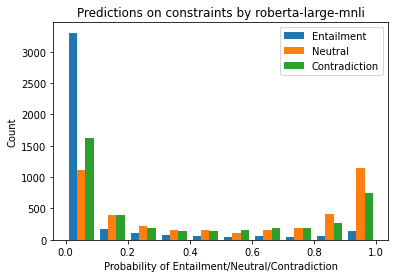

In [15]:
# note that entail and contradiction are flipped
plot("Predictions on constraints by roberta-large-mnli", roberta[2], roberta[1], roberta[0])

In [18]:
roberta_contra = test_constraint_knowledge(roberta_flip_config, contra_test=True)

100%|██████████| 4060/4060 [01:23<00:00, 48.42it/s]

Entailment: 157, Neutral: 619, Contradiction: 3284


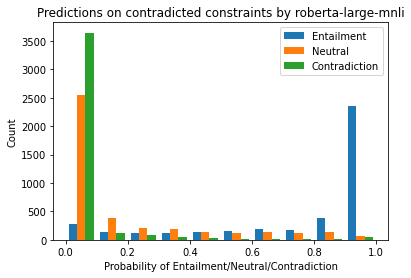

In [19]:
# note that entail and contradiction are flipped
plot("Predictions on contradicted constraints by roberta-large-mnli", roberta_contra[2], roberta_contra[1], roberta_contra[0])


Now get final results for each model

In [7]:
# baseline run, results_03_13_09:26:12.json 
baseline_config = {"name": "Baseline", "nli_model": "ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli", "qa_model": "allenai/macaw-large", "sentence_model": "paraphrase-MiniLM-L6-v2", "enable_flip": False, "feedback_type": None}
baseline_f1 = [0.800498753117207, 0.7802874743326488, 0.7716460513796384, 0.776243093922652, 0.7710360618202632, 0.772587147261086, 0.7800040477636107, 0.7758085145258542, 0.7810593900481542, 0.7718326286630705]
baseline_consistencies = [0.7843750000000169, 0.7841669948798825, 0.787409975993604, 0.7937524253007413, 0.7928853754940745, 0.7935228023793814, 0.7950887087298814, 0.7937388755104199, 0.7931424265260004, 0.7876838235294136]

# first flip run (last night), results_03_13_09:27:42.json
flip_config = {'name': 'Flip only', 'nli_model': 'ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli', 'qa_model': 'allenai/macaw-large', 'sentence_model': 'paraphrase-MiniLM-L6-v2', 'enable_flip': True, 'sentence_similarity_threshold': 0.6, 'default_flipped_confidence': 0.9, 'flip_premise_threshold': 1.2, 'flip_entailing_premises': True, 'feedback_type': None}
flip_f1 = [0.7955801104972374, 0.8061302681992337, 0.8061932728243459, 0.807346619773349, 0.7998712998712999, 0.800320341697811, 0.8021753908905507, 0.801063177264363, 0.8084496956677407, 0.8019559902200488]
flip_consistencies = [0.7791095890411148, 0.8065710319296712, 0.8099337748344434, 0.8083354130272071, 0.8010315413608451, 0.8057673185283426, 0.8068914956011759, 0.808800211416493, 0.8119299087854079, 0.8083289404322636]

# old flip + relevant feedback (sylvia)
flip_fbrelevant_config = {'name': 'Relevant feedback', 'nli_model': 'ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli', 'qa_model': 'allenai/macaw-large', 'sentence_model': 'paraphrase-MiniLM-L6-v2', 'enable_flip': True, 'feedback_type': 'relevant', 'sentence_similarity_threshold': 0.6, 'default_flipped_confidence': 0.7, 'flip_premise_threshold': 0.1, 'max_retrieved': 30}
flip_fbrelevant_f1 = [0.8165137614678899, 0.8148760330578513, 0.8160458452722062, 0.8140409527789386, 0.7995802728226652, 0.8024124066628375, 0.8034271725826193, 0.8028356225077535, 0.8081272762123825, 0.8039631988676575]
flip_fbrelevant_consistencies = [0.7888631090487483, 0.8023327194598034, 0.8181436371272651, 0.8125979316828639, 0.8081045751634037, 0.805476451259588, 0.8035509736540702, 0.8094823078263934, 0.812185833968015, 0.8107395587623171]

# new flip + on topic feedback
flip_fbtopic = {'name': 'On topic feedback', 'nli_model': 'ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli', 'qa_model': 'allenai/macaw-large', 'sentence_model': 'paraphrase-MiniLM-L6-v2', 'enable_flip': True, 'feedback_type': 'topic', 'sentence_similarity_threshold': 0.6, 'default_flipped_confidence': 0.7, 'flip_premise_threshold': 0.1, 'max_retrieved': 30}
flip_fbtopic_f1 = [0.8677098150782362, 0.8571428571428571, 0.8438356164383561, 0.841980198019802, 0.8369028006589785, 0.8371714982389596, 0.8343016500116197, 0.8318695106649937, 0.8389907424214922, 0.8352053646269908]
flip_fbtopic_consistencies = [0.8473118279570057, 0.8505376344086102, 0.8352852285606409, 0.8340318524727623, 0.8324535230663339, 0.8327223615666635, 0.831374552887075, 0.8311111111111137, 0.834605944914101, 0.8315578393282388]

# sat
sat_config = {'name': 'SAT Flip only', 'nli_model': 'ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli', 'qa_model': 'allenai/macaw-large', 'sentence_model': 'paraphrase-MiniLM-L6-v2', 'enable_flip': True, 'sentence_similarity_threshold': 0.75, 'default_flipped_confidence': 0.5, 'flip_premise_threshold': 0.25, 'feedback_type': None, 'max_sat': True, 'max_sat_lmbda': 1}
sat_f1 = [0.8471615720524018, 0.8024316109422492, 0.8050314465408805, 0.810318664643399, 0.8054187192118226, 0.8, 0.8076923076923076, 0.806201550387597, 0.7935393258426966, 0.7853939782190904]
sat_consistencies = [0.7631578947374654, 0.8152173913045486, 0.8593750000000733, 0.8278388278388908, 0.8170731707317631, 0.7994722955145648, 0.8066666666667096, 0.8090551181102739, 0.7979094076655404, 0.7971698113207866]

# sat with topic feedback 
sat_fbtopic_config = {'name': 'SAT Flip Topic Feedback only', 'nli_model': 'ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli', 'qa_model': 'allenai/macaw-large', 'sentence_model': 'paraphrase-MiniLM-L6-v2', 'enable_flip': True, 'sentence_similarity_threshold': 0.75, 'default_flipped_confidence': 0.5, 'flip_premise_threshold': 0.25, 'feedback_type': 'topic', 'max_sat': True, 'max_sat_lmbda': 1, 'max_retrieved': 30}
sat_fbtopic_f1 = [0.8557692307692307, 0.8169934640522877, 0.8225108225108224, 0.8160000000000001, 0.8103896103896104, 0.8092243186582809, 0.818840579710145, 0.8158319870759289, 0.8084795321637427, 0.8010645375914837]
sat_fbtopic_consistencies = [0.9310344827588585, 0.8615384615386745, 0.898734177215254, 0.8640350877193579, 0.8566433566434067, 0.8414634146341946, 0.8333333333333748, 0.8407079646018052, 0.8294573643411183, 0.8227194492255039]

# sat with relevant feedback
sat_fbrelevant_config = {'name': 'SAT Flip And relevant feedback', 'nli_model': 'ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli', 'qa_model': 'allenai/macaw-large', 'sentence_model': 'paraphrase-MiniLM-L6-v2', 'enable_flip': True, 'sentence_similarity_threshold': 0.75, 'default_flipped_confidence': 0.5, 'flip_premise_threshold': 0.25, 'feedback_type': 'relevant', 'max_sat': True, 'max_sat_lmbda': 1, 'max_retrieved': 30}
sat_fbrelevant_f1 = [0.8054298642533936, 0.7645259938837919, 0.7770961145194274, 0.7689969604863222, 0.7622549019607842, 0.7658730158730158, 0.7709401709401709, 0.7637195121951219, 0.7543014452856159, 0.75125]
sat_fbrelevant_consistencies = [0.6666666666675214, 0.6829268292686794, 0.8042328042329078, 0.7709923664123012, 0.7704402515723993, 0.7563025210084716, 0.7656612529002864, 0.7700421940928756, 0.7733089579525094, 0.7693548387097147]

# the second flip run (this morning)
# the feedback_relevant_config (this morning)
# the feedback_topic_config (this morning)

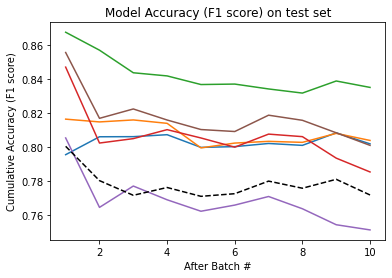

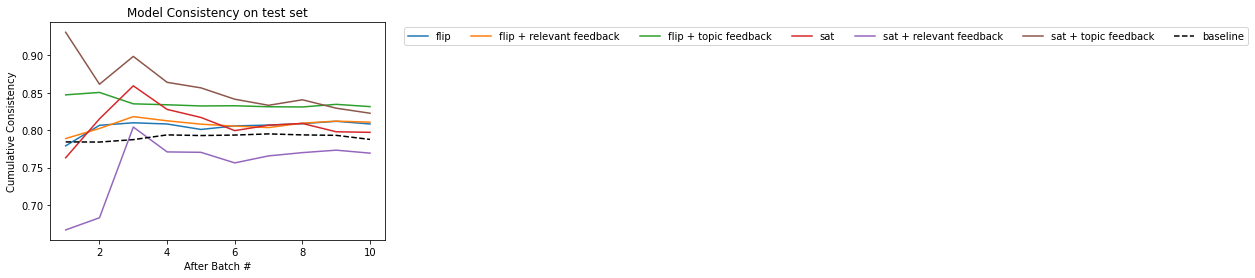

In [23]:
from matplotlib import pyplot as plt
b = range(1, len(baseline_f1)+1)

# Plot accuracy and consistency
plt.plot(b, flip_f1, label='flip')
plt.plot(b, flip_fbrelevant_f1, label='flip + relevant feedback')
plt.plot(b, flip_fbtopic_f1, label='flip + topic feedback')
plt.plot(b, sat_f1, label='sat')
plt.plot(b, sat_fbrelevant_f1, label='sat + relevant feedback')
plt.plot(b, sat_fbtopic_f1, label='sat + topic feedback')
plt.plot(b, baseline_f1, '--', color='black', label='baseline')
plt.xlabel('After Batch #')
plt.ylabel('Cumulative Accuracy (F1 score)')
plt.title('Model Accuracy (F1 score) on test set')
plt.savefig('final_figures/accuracy.png', dpi=1200)
plt.show()
plt.close()

# Plot consistency
plt.plot(b, flip_consistencies,  label='flip')
plt.plot(b, flip_fbrelevant_consistencies, label='flip + relevant feedback')
plt.plot(b, flip_fbtopic_consistencies, label='flip + topic feedback')
plt.plot(b, sat_consistencies, label='sat')
plt.plot(b, sat_fbrelevant_consistencies, label='sat + relevant feedback')
plt.plot(b, sat_fbtopic_consistencies, label='sat + topic feedback')
plt.plot(b, baseline_consistencies, '--', color='black', label='baseline')
plt.xlabel('After Batch #')
plt.ylabel('Cumulative Consistency')
plt.title('Model Consistency on test set')
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left" ,ncol=7)
plt.savefig('final_figures/consistency.png', dpi=1200)
plt.show()
plt.close()